# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [124]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [125]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.002 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [126]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [127]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features,activation=None, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activation = activation

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.activation == "relu":
            return tf.nn.relu(y)
        elif self.activation == "sigmoid":
            return tf.nn.sigmoid(y)
        elif self.activation == "softmax":
            return tf.nn.softmax(y)
        else:
            return y


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1,activation="relu")
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2,activation="relu")
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x=self.layer_2(x)
    return self.output_layer(x)




In [128]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # y_true – це індекси класів (0..9), без one-hot
    y_true = tf.cast(y_true, tf.int32)
    return tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    )
# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    # 1. Знаходимо індекс з найбільшим значенням (клас) для кожного передбачення.
    #    Наприклад, [0.1, 0.9, 0.0] -> 1
    predicted_classes = tf.argmax(y_pred, axis=1)

    # 2. Перевіряємо, чи збігаються передбачені класи зі справжніми мітками.
    #    Це повертає булевий тензор, наприклад, [True, False, True, ...].
    correct_predictions = tf.equal(predicted_classes, tf.cast(y_true, dtype=tf.int64))

    # 3. Перетворюємо булеві значення на числа (True -> 1, False -> 0).
    #    [True, False, True, ...] -> [1, 0, 1, ...]
    correct_predictions = tf.cast(correct_predictions, dtype=tf.float32)

    # 4. Обчислюємо середнє арифметичне (середнє) цих значень.
    #    Це і є точність.
    return tf.reduce_mean(correct_predictions)


In [129]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")


# --- Оптимізатор створюємо один раз ---
optimizer = tf.optimizers.SGD(learning_rate)

# --- Функція навчання ---
def train(neural_net, input_x, output_y):
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Збираємо всі параметри (ваги і біаси) з шарів
    trainable_variables = []
    for layer in [neural_net.layer_1, neural_net.layer_2, neural_net.output_layer]:
        trainable_variables.extend([layer.w, layer.b])

    # Рахуємо градієнти і застосовуємо їх
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, pred


In [119]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss, preds = train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        acc = accuracy(preds, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step {step}, Loss: {loss.numpy():.4f}, Accuracy: {acc.numpy():.4f}")



Step 100, Loss: 97.9887, Accuracy: 0.6719
Step 200, Loss: 69.8632, Accuracy: 0.7500
Step 300, Loss: 69.9660, Accuracy: 0.6992
Step 400, Loss: 53.8242, Accuracy: 0.7969
Step 500, Loss: 40.7622, Accuracy: 0.8203
Step 600, Loss: 39.7940, Accuracy: 0.7773
Step 700, Loss: 27.0781, Accuracy: 0.8672
Step 800, Loss: 34.2871, Accuracy: 0.8242
Step 900, Loss: 41.6701, Accuracy: 0.8594
Step 1000, Loss: 26.3485, Accuracy: 0.8633
Step 1100, Loss: 40.4696, Accuracy: 0.8398
Step 1200, Loss: 16.8119, Accuracy: 0.8633
Step 1300, Loss: 24.0981, Accuracy: 0.8633
Step 1400, Loss: 17.7674, Accuracy: 0.8594
Step 1500, Loss: 23.0214, Accuracy: 0.8477
Step 1600, Loss: 27.7328, Accuracy: 0.8516
Step 1700, Loss: 11.9047, Accuracy: 0.8945
Step 1800, Loss: 18.0790, Accuracy: 0.8828
Step 1900, Loss: 11.7320, Accuracy: 0.8789
Step 2000, Loss: 23.0589, Accuracy: 0.8672
Step 2100, Loss: 14.6191, Accuracy: 0.8867
Step 2200, Loss: 17.8231, Accuracy: 0.8828
Step 2300, Loss: 13.5199, Accuracy: 0.9141
Step 2400, Loss: 12.

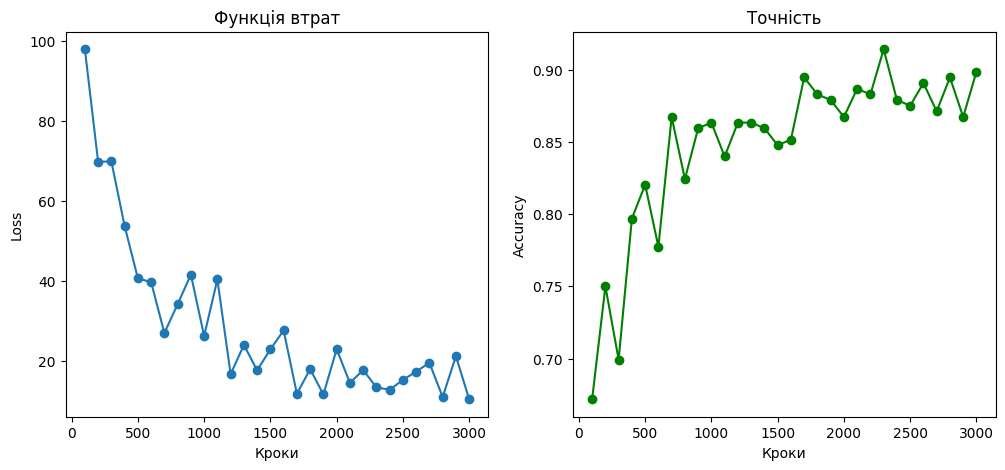

In [120]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Виведіть графік функції втрат
plt.plot(range(display_step, training_steps+1, display_step), loss_history, marker="o")
plt.title("Функція втрат")
plt.xlabel("Кроки")
plt.ylabel("Loss")
# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(display_step, training_steps+1, display_step), accuracy_history, marker="o", color="green")
plt.title("Точність")
plt.xlabel("Кроки")
plt.ylabel("Accuracy")

plt.show()


In [121]:
# Обчисліть точність навченої нейромережі
train_preds = neural_net(x_train)
train_acc = accuracy(train_preds, y_train)
print(f"Точність на тренувальних даних: {train_acc.numpy():.4f}")
# Тестування моделі на тестових даних
test_preds = neural_net(x_test)
test_acc = accuracy(test_preds, y_test)
print(f"Точність на тестових даних: {test_acc.numpy():.4f}")

Точність на тренувальних даних: 0.8914
Точність на тестових даних: 0.8791


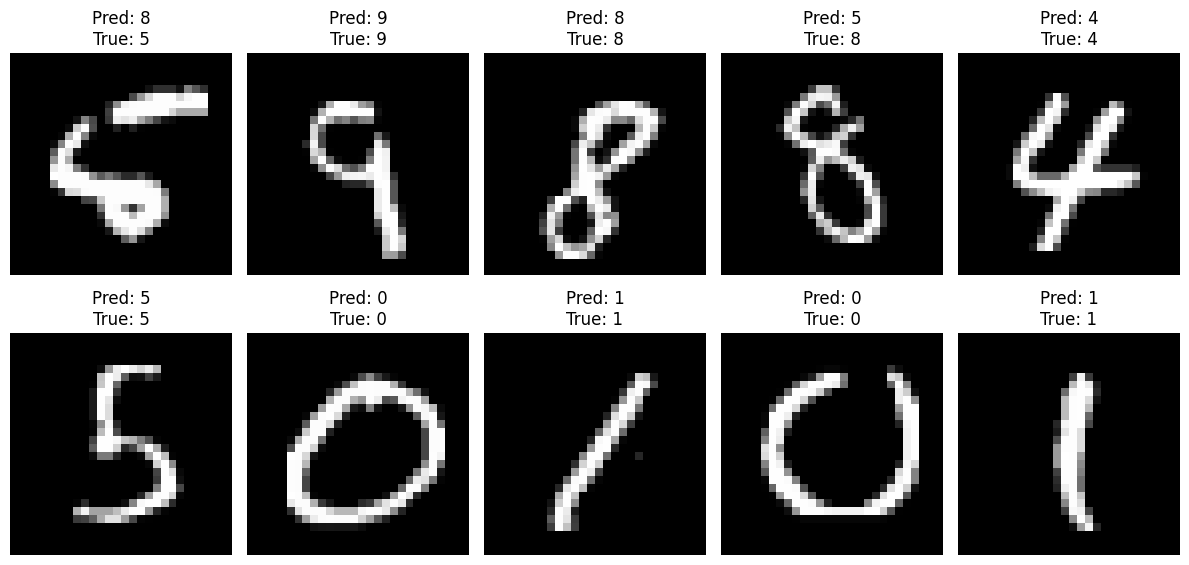

In [122]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

plt.figure(figsize=(12, 6))

for i in range(10):
    idx = random.randint(0, x_test.shape[0] - 1)   # випадковий індекс
    img = x_test[idx].reshape(1, -1)               # 1 зображення у форматі вектора
    true_label = y_test[idx]                       # справжня мітка

    # Передбачення
    pred = neural_net(img)
    pred_label = tf.argmax(pred, axis=1).numpy()[0]

    # Вивід зображення
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()



In [123]:
#метрики якості для кожного класу навченої моделі
from sklearn.metrics import classification_report

# Отримуємо передбачення на тестових даних
y_pred = neural_net(x_test)
y_pred_labels = tf.argmax(y_pred, axis=1).numpy()

# Друкуємо звіт
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       980
           1       0.96      0.95      0.95      1135
           2       0.86      0.88      0.87      1032
           3       0.87      0.84      0.85      1010
           4       0.89      0.86      0.87       982
           5       0.81      0.85      0.83       892
           6       0.91      0.91      0.91       958
           7       0.90      0.87      0.88      1028
           8       0.82      0.82      0.82       974
           9       0.82      0.86      0.84      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

